## Import libraries

In [1]:
import os
import pickle 
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-12-02 18:19:03.093842: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 18:19:03.497469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 18:19:03.497531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 18:19:03.574977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 18:19:03.696787: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-12-02 18:19:07.607838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 18:19:07.874124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 18:19:07.874224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
DATASET = 'Images'

BASE_DIR = './' + DATASET
WORKING_DIR = './'

## Load the captions

In [4]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    captions_doc = f.read()

In [5]:
captions_original = sc.parallelize(captions_doc.split('\n')[1:])

In [6]:
captions = captions_original.map(lambda x: x.split(',')) \
    .filter(lambda x: len(x) > 1) \
    .map(lambda x: (x[0].split('.')[0], x[1:]))

In [7]:
mapping = captions.reduceByKey(lambda x, y: x + y).collectAsMap()

In [8]:
image_ids = captions.map(lambda x: x[0])
image_ids.take(10)

['1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70']

In [9]:
len(mapping)

8091

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Preprocess data

In [11]:
import re

captions_processed = captions \
    .map(lambda x: (x[0], x[1][0])) \
    .map(lambda x: (x[0], x[1].lower())) \
    .map(lambda x: (x[0], re.sub('[^A-Za-z]', ' ', x[1]))) \
    .map(lambda x: (x[0], 'start ' + x[1] + ' end')) \
    .map(lambda x: (x[0], [re.sub('\s+', ' ', x[1])]))

In [12]:
mapping = captions_processed.reduceByKey(lambda x, y: x + y).collectAsMap()

In [13]:
mapping['1000268201_693b08cb0e']

['<START> a child in a pink dress is climbing up a set of stairs in an entry way <END>',
 '<START> a girl going into a wooden building <END>',
 '<START> a little girl climbing into a wooden playhouse <END>',
 '<START> a little girl climbing the stairs to her playhouse <END>',
 '<START> a little girl in a pink dress going into a wooden cabin <END>']

In [14]:
all_captions = captions_processed.map(lambda x: x[1][0]).collect()
all_captions[:10]

['<START> a child in a pink dress is climbing up a set of stairs in an entry way <END>',
 '<START> a girl going into a wooden building <END>',
 '<START> a little girl climbing into a wooden playhouse <END>',
 '<START> a little girl climbing the stairs to her playhouse <END>',
 '<START> a little girl in a pink dress going into a wooden cabin <END>',
 '<START> a black dog and a spotted dog are fighting <END>',
 '<START> a black dog and a tri colored dog playing with each other on the road <END>',
 '<START> a black dog and a white dog with brown spots are staring at each other in the street <END>',
 '<START> two dogs of different breeds looking at each other on the road <END>',
 '<START> two dogs on pavement moving toward each other <END>']

In [15]:
len(all_captions)

40455

In [16]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8274

In [18]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Extract the image features

In [19]:
from tensorflow.keras.models import Model

vgg_model = VGG16()
vgg_model = Model(inputs = vgg_model.inputs , outputs = vgg_model.layers[-2].output)
def vgg16_features(img_name):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = vgg_model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]
    return image_id, feature

2023-12-02 18:19:30.110636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 18:19:30.110802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 18:19:30.110833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 18:19:30.485004: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 18:19:30.485068: I external/local_xla/xla/stream_executor

In [20]:
directory = BASE_DIR

In [21]:
all_files = sc.parallelize(os.listdir(directory))
image_file_names = all_files.filter(lambda x: x.endswith(".jpg"))

In [ ]:
# extract features from image
features = {}
directory = BASE_DIR

for img_name in tqdm(image_file_names.collect()):
    image_id, feature = vgg16_features(img_name)
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
pickle.dump(features, open(os.path.join(WORKING_DIR, DATASET + 'features.pkl'), 'wb'))

In [22]:
with open(os.path.join(WORKING_DIR, DATASET + 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## CNN and LTSM RNN model

In [23]:
import numpy as np

def one_hot_encode(character, char_to_idx, char_size):
    encoded = np.zeros((char_size, 1))
    encoded[char_to_idx[character]] = 1
    return encoded

def xavier_normalized_init(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

def sigmoid_activation(x, derivative=False):
    if derivative:
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

def tanh_activation(x, derivative=False):
    if derivative:
        return 1 - x ** 2
    return np.tanh(x)

def softmax_activation(x):
    return np.exp(x) / np.sum(np.exp(x))

class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        self.forget_gate_weights = xavier_normalized_init(input_size, hidden_size)
        self.forget_gate_biases = np.zeros((hidden_size, 1))

        self.input_gate_weights = xavier_normalized_init(input_size, hidden_size)
        self.input_gate_biases = np.zeros((hidden_size, 1))

        self.candidate_gate_weights = xavier_normalized_init(input_size, hidden_size)
        self.candidate_gate_biases = np.zeros((hidden_size, 1))

        self.output_gate_weights = xavier_normalized_init(input_size, hidden_size)
        self.output_gate_biases = np.zeros((hidden_size, 1))

        self.final_gate_weights = xavier_normalized_init(hidden_size, output_size)
        self.final_gate_biases = np.zeros((output_size, 1))

    def reset_network_memory(self):
        self.concatenated_inputs = {}

        self.hidden_states = {-1: np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1: np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    def forward_propagation(self, inputs):
        self.reset_network_memory()
        outputs = []

        for time_step in range(len(inputs)):
            self.concatenated_inputs[time_step] = np.concatenate((self.hidden_states[time_step - 1], inputs[time_step]))

            self.forget_gates[time_step] = sigmoid_activation(
                np.dot(self.forget_gate_weights, self.concatenated_inputs[time_step]) + self.forget_gate_biases)
            
            self.input_gates[time_step] = sigmoid_activation(
                np.dot(self.input_gate_weights, self.concatenated_inputs[time_step]) + self.input_gate_biases)
            
            self.candidate_gates[time_step] = tanh_activation(
                np.dot(self.candidate_gate_weights, self.concatenated_inputs[time_step]) + self.candidate_gate_biases)
            
            self.output_gates[time_step] = sigmoid_activation(
                np.dot(self.output_gate_weights, self.concatenated_inputs[time_step]) + self.output_gate_biases)
            
            self.cell_states[time_step] = (
                self.forget_gates[time_step] * self.cell_states[time_step - 1] +
                self.input_gates[time_step] * self.candidate_gates[time_step]
            )
            
            self.hidden_states[time_step] = self.output_gates[time_step] * tanh_activation(self.cell_states[time_step])

            outputs.append(np.dot(self.final_gate_weights, self.hidden_states[time_step]) + self.final_gate_biases)

        return outputs

    def backward_propagation(self, errors, inputs):
        d_forget_gate_weights, d_forget_gate_biases = 0, 0
        d_input_gate_weights, d_input_gate_biases = 0, 0
        d_candidate_gate_weights, d_candidate_gate_biases = 0, 0
        d_output_gate_weights, d_output_gate_biases = 0, 0
        d_final_gate_weights, d_final_gate_biases = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])

        for time_step in reversed(range(len(inputs))):
            error = errors[time_step]

            d_final_gate_weights += np.dot(error, self.hidden_states[time_step].T)
            d_final_gate_biases += error

            d_hidden_state = np.dot(self.final_gate_weights.T, error) + dh_next

            d_output_gate = tanh_activation(self.cell_states[time_step]) * d_hidden_state * sigmoid_activation(
                self.output_gates[time_step], derivative=True)
            d_output_gate_weights += np.dot(d_output_gate, inputs[time_step].T)
            d_output_gate_biases += d_output_gate

            d_cell_state = (
                tanh_activation(tanh_activation(self.cell_states[time_step]), derivative=True) * 
                self.output_gates[time_step] * d_hidden_state + dc_next
            )

            d_forget_gate = (
                d_cell_state * self.cell_states[time_step - 1] * 
                sigmoid_activation(self.forget_gates[time_step], derivative=True)
            )
            d_forget_gate_weights += np.dot(d_forget_gate, inputs[time_step].T)
            d_forget_gate_biases += d_forget_gate

            d_input_gate = (
                d_cell_state * self.candidate_gates[time_step] * 
                sigmoid_activation(self.input_gates[time_step], derivative=True)
            )
            d_input_gate_weights += np.dot(d_input_gate, inputs[time_step].T)
            d_input_gate_biases += d_input_gate

            d_candidate_gate = (
                d_cell_state * self.input_gates[time_step] * 
                tanh_activation(self.candidate_gates[time_step], derivative=True)
            )
            d_candidate_gate_weights += np.dot(d_candidate_gate, inputs[time_step].T)
            d_candidate_gate_biases += d_candidate_gate

            d_concatenated_input = (
                np.dot(self.forget_gate_weights.T, d_forget_gate) + 
                np.dot(self.input_gate_weights.T, d_input_gate) + 
                np.dot(self.candidate_gate_weights.T, d_candidate_gate) + 
                np.dot(self.output_gate_weights.T, d_output_gate)
            )

            dh_next = d_concatenated_input[:self.hidden_size, :]
            dc_next = self.forget_gates[time_step] * d_cell_state

        gradients = [d_forget_gate_weights, d_forget_gate_biases, d_input_gate_weights, d_input_gate_biases,
                     d_candidate_gate_weights, d_candidate_gate_biases, d_output_gate_weights, d_output_gate_biases,
                     d_final_gate_weights, d_final_gate_biases]

        for gradient in gradients:
            np.clip(gradient, -1, 1, out=gradient)

        self.forget_gate_weights += d_forget_gate_weights * self.learning_rate
        self.forget_gate_biases += d_forget_gate_biases * self.learning_rate

        self.input_gate_weights += d_input_gate_weights * self.learning_rate
        self.input_gate_biases += d_input_gate_biases * self.learning_rate

        self.candidate_gate_weights += d_candidate_gate_weights * self.learning_rate
        self.candidate_gate_biases += d_candidate_gate_biases * self.learning_rate

        self.output_gate_weights += d_output_gate_weights * self.learning_rate
        self.output_gate_biases += d_output_gate_biases * self.learning_rate

        self.final_gate_weights += d_final_gate_weights * self.learning_rate
        self.final_gate_biases += d_final_gate_biases * self.learning_rate

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model

# Define Input Layers
image_input = Input(shape=(4096,))
text_input = Input(shape=(max_length,))

# Image Feature Extraction
image_dropout = Dropout(0.4)(image_input)
image_features = Dense(256, activation='relu')(image_dropout)

# Text Processing
text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
text_dropout = Dropout(0.4)(text_embedding)
text_lstm = LSTM(256)(text_dropout)

# Combine Image and Text Features
merged_features = add([image_features, text_lstm])

# Decoder Layers
decoder_dense1 = Dense(256, activation='relu')(merged_features)
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense1)

# Create Model
model = Model(inputs=[image_input, text_input], outputs=output_layer)

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam')

2023-12-02 18:20:29.247520: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


# Train Model

In [26]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [27]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_sequence_length, vocab_size, batch_size):
    X_image, X_sequence, y = [], [], []
    batch_count = 0

    while True:
        for key in data_keys:
            batch_count += 1
            captions = mapping[key]

            for caption in captions:
                sequence = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(sequence)):
                    input_sequence, output_sequence = sequence[:i], sequence[i]
                    input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length)[0]
                    output_sequence = to_categorical([output_sequence], num_classes=vocab_size)[0]

                    X_image.append(features[key][0])
                    X_sequence.append(input_sequence)
                    y.append(output_sequence)

            if batch_count == batch_size:
                X_image, X_sequence, y = np.array(X_image), np.array(X_sequence), np.array(y)
                yield [X_image, X_sequence], y
                X_image, X_sequence, y = [], [], []
                batch_count = 0

In [28]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2023-12-02 18:20:40.030271: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2023-12-02 18:20:40.899164: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff1f9ac6f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 18:20:40.899232: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Co

227/227 [==============================] - 88s 387ms/step - loss: 2.2700


In [29]:
model.save(WORKING_DIR+'/my_model.keras')

# Generate Captions for the Image

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
import numpy as np

def predict_caption(model, image, tokenizer, max_length):
    # Initialize the input text with the start tag for the generation process
    input_text = 'start'

    # Iterate over the max length of the sequence
    for _ in range(max_length):
        # Encode the input sequence
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        
        # Predict the next word
        predictions = model.predict([image, sequence], verbose=0)
        
        # Get the index with the highest probability
        predicted_index = np.argmax(predictions)
        
        # Convert the index to a word
        predicted_word = idx_to_word(predicted_index, tokenizer)
        
        # Stop if the word is not found
        if predicted_word is None:
            break
        
        # Append the predicted word as input for generating the next word
        input_text += " " + predicted_word
        
        # Stop if we reach the end tag
        if predicted_word == 'end':
            break

    return input_text

# Model Validation

In [32]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual_captions, predicted_captions = list(), list()

for key in tqdm(test):
    actual_captions_list = [caption.split() for caption in mapping[key]]
    
    predicted_caption = predict_caption(model, features[key], tokenizer, max_length)
    predicted_captions_list = predicted_caption.split()
    
    actual_captions.append(actual_captions_list)
    predicted_captions.append(predicted_captions_list)

# Calculate BLEU score
bleu_score_1 = corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0))
bleu_score_2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))

print("BLEU-1: %f" % bleu_score_1)
print("BLEU-2: %f" % bleu_score_2)

100%|█████████████████████████████████████████████████████████████████████████████████| 810/810 [49:10<00:00,  3.64s/it]


BLEU-1: 0.221365
BLEU-2: 0.153815


## Results

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, '', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('Predicted')
    print(y_pred)
    plt.imshow(image)

Actual
<START> a black dog and a spotted dog are fighting <END>
<START> a black dog and a tri colored dog playing with each other on the road <END>
<START> a black dog and a white dog with brown spots are staring at each other in the street <END>
<START> two dogs of different breeds looking at each other on the road <END>
<START> two dogs on pavement moving toward each other <END>
Predicted
<START> two dogs play with a red ball end end of a house end end end end end end end end end end end end end end end end end end end end end end end


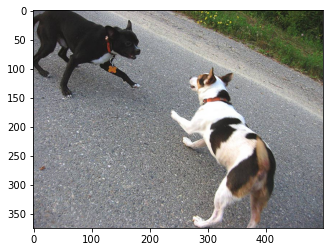

In [37]:
generate_caption("1001773457_577c3a7d70.jpg")

Actual
<START> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <END>
<START> a little girl is sitting in front of a large painted rainbow <END>
<START> a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it <END>
<START> there is a girl with pigtails sitting in front of a rainbow painting <END>
<START> young girl with pigtails painting outside in the grass <END>
Predicted
<START> a little girl in pigtails sits on a rock with a rainbow painted painted in the background end end end end end end end end end end end end end end end end end end


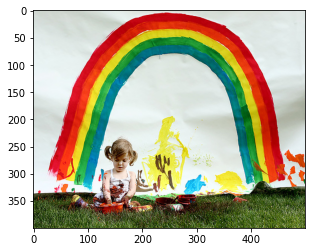

In [38]:
generate_caption("1002674143_1b742ab4b8.jpg")

Actual
<START> a man in a hat is displaying pictures next to a skier in a blue hat <END>
<START> a man skis past another man displaying paintings in the snow <END>
<START> a person wearing skis looking at framed pictures set up in the snow <END>
<START> a skier looks at framed pictures in the snow next to trees <END>
<START> man on skis looking at artwork for sale in the snow <END>
Predicted
<START> a man in a horned skis skis in a snow covered slope end end a snow covered slope end end end end end end end end end end end end end end end end end


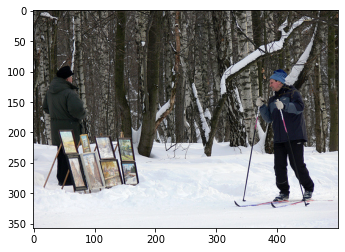

In [39]:
generate_caption("101669240_b2d3e7f17b.jpg")